In [1]:
import numpy as np
import pandas as pd

In [2]:
import random

In [3]:
from tqdm import tqdm

In [4]:
import re
import os

In [31]:
from collections import Counter

In [12]:
from sklearn.model_selection import train_test_split

#### Metrics

In [92]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [112]:
from Levenshtein import distance as levenshtein_distance

#### Visualisation

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

In [84]:
import seaborn as sns

### Load data

In [8]:
prepared_dir = '../data/prepared'
filenames_csv = ['01_punct_pushkin.csv']

In [9]:
data_df = pd.DataFrame()

for ind, filename in enumerate(filenames_csv):
    part_df = pd.read_csv(os.path.join(prepared_dir, filename), index_col=0)
    if ind == 0:
        data_df = part_df
    else:       
        data_df = pd.concat([data_df, part_df], ignore_index=True)

print(f'Data shape: {data_df.shape}')

Data shape: (4455, 2)


In [10]:
data_df.sample(5)

,input,target
971,при сих словах он поскакал назад держась одной...,S S S S S C S S S S C S S S S S P
25,да вот пошел семнадцатый годок отвечала матушка,S S S S C S P
1668,кстати же я подоспел сказал он нам,S S S C S S P
594,они громко роптали и иван игнатьич исполнитель...,S S C S S C S S C S S C S S C S S S C S EX
4214,я решился посетить знакомую сторону взял вольн...,S S S S C S S S S S S S S S S P


### Splitting on train and test datasets

In [15]:
splitting_random_state = 78
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    data_df['input'], data_df['target'],
    test_size=0.33,
    random_state=42
)

print(f'Train size : {X_train.shape[0]}')
print(f'Test size  : {X_test.shape[0]}')

Train size : 2984
Test size  : 1471


### Random model based on punctuation statistics

During `fit` function we count number of each punctuation mark in the train dataset and calculate _probabilities_ of appearance of each mark in texts (for intrinsic and finalizing punctuation separately).

Based on the obtained _probabilities_ in `predict` function we will be generating sequences of punctuation for each input sentence.

In [126]:
END_PUNC = ['P', 'EX', 'Q']
INTR_PUNC = ['S', 'C']

NAMES_PUNC = {
    'S': 'space (` `)',
    'C': 'comma (`,`)',
    'P': 'period (`.`)',
    'EX': 'exclamation (`!`)',
    'Q': 'question (`?`)'
}

In [66]:
def fit_statistic_model(X_train, y_train):
    '''
    Learn the punctuation statistics using the train set
    '''
    all_punct = []  # analyse all punctuation in train dataset
    
    for ind_row in range(y_train.shape[0]):
        target = y_train.iloc[ind_row]
        all_punct.extend(target.split(' '))

    punct_counter = Counter(all_punct)

    # define probabilities for intrinsic punctuation marks:
    #     'S' (spaces) and 'C' (comma)
    intr_punct_num = sum([punct_counter[mark] for mark in INTR_PUNC])  # number of all intrinsic punctuation marks
    intr_probas = {mark:punct_counter[mark] / intr_punct_num for mark in INTR_PUNC}
    assert sum(intr_probas.values()) == 1
    
    # define probabilities for finalizing punctuation marks: 
    #     'P' (period), 'EX' (exclamation) and 'Q' (question)
    end_punct_num = sum([punct_counter[mark] for mark in END_PUNC])  # number of all end punctuation marks (=size(train))
    assert end_punct_num == X_train.shape[0]
    end_probas = {mark:punct_counter[mark] / end_punct_num for mark in END_PUNC}
    assert sum(end_probas.values()) == 1
    
    return intr_probas, end_probas


def predict_statistic_model(X_test, intr_probas, end_probas):
    '''
    Returns predictions based on punctuation statistics
    '''
    y_pred_list = []
    
    for x in X_test:
        y_list = []
        len_x = len(x.split(' '))
        
        for i in range(len_x):
            if i == len_x - 1:
                mark = np.random.choice(list(end_probas.keys()), p=list(end_probas.values()))
            else:
                mark = np.random.choice(list(intr_probas.keys()), p=list(intr_probas.values()))
            y_list.append(mark)

        assert len_x == len(y_list)
        y_pred_list.append(' '.join(y_list))

    assert len(y_pred_list) == X_test.shape[0]
        
    return pd.Series(y_pred_list, index=X_test.index)

In [67]:
intr_probas, end_probas = fit_statistic_model(X_train, y_train)
y_pred = predict_statistic_model(X_test, intr_probas, end_probas)

In [70]:
target_vs_pred_df = pd.DataFrame()

target_vs_pred_df['target'] = y_test
target_vs_pred_df['predicted'] = y_pred

target_vs_pred_df.sample(5)

,target,predicted
3409,S S S S C S S S S P,S S S S S S S S C P
1113,C S C S S S S P,S S S S S S C P
755,S S S S S C S S S S S S S S S S S S S S S S P,C C C S S C S S S S C S S S S S S S S S S C Q
324,C S S S C S S S S S S S P,C S S S S S S C S S S C P
3589,S S S S S S S S S C S S S C S S S P,C S S S S S S S S S S C C S S C S P


### Metrics (Classification)

The task can be understood as a multi-class ($5$) classification.

Hence, we can calculate metrics like `F1`, `Presision` an `Recall` for separate classes (like in [that project on punctuation prediction](https://habr.com/ru/articles/581946/)).

In [137]:
def return_separate_punct(target_vs_pred_df):
    test_all_punc_target = []  # list of all punctuation
    test_all_punc_preds = []
    
    for target_this, predicted_this in zip(target_vs_pred_df['target'], target_vs_pred_df['predicted']):
        test_all_punc_target.extend(target_this.split(' '))
        test_all_punc_preds.extend(predicted_this.split(' '))
    
    assert len(test_all_punc_target) == len(test_all_punc_preds)
    
    return test_all_punc_target, test_all_punc_preds

In [138]:
test_all_punc_target, test_all_punc_preds = return_separate_punct(target_vs_pred_df)

print(f'Number of all punctuation marks in train dataset: {len(test_all_punc_target)}')

Number of all punctuation marks in train dataset: 19264


In [156]:
n_experiments = 5  # perform several predictions

for n in tqdm(range(n_experiments)):
    y_pred = predict_statistic_model(X_test, intr_probas, end_probas)
    
    target_vs_pred_df = pd.DataFrame()
    target_vs_pred_df['target'] = y_test
    target_vs_pred_df['predicted'] = y_pred
    
    test_all_punc_target, test_all_punc_preds = return_separate_punct(target_vs_pred_df)

    if n == 0:
        cm = confusion_matrix(test_all_punc_target, test_all_punc_preds)
        # precision = TP / (TP + FP)
        precision = precision_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
        # recall = TP / (TP + FN)
        recall = recall_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
        # f1 = 2TP / (2TP + FP + FN)
        f1 = f1_score(test_all_punc_target, test_all_punc_preds, average=None)
    else:
        cm += confusion_matrix(test_all_punc_target, test_all_punc_preds)
        precision += precision_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
        recall += recall_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
        f1 += f1_score(test_all_punc_target, test_all_punc_preds, average=None)

100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]


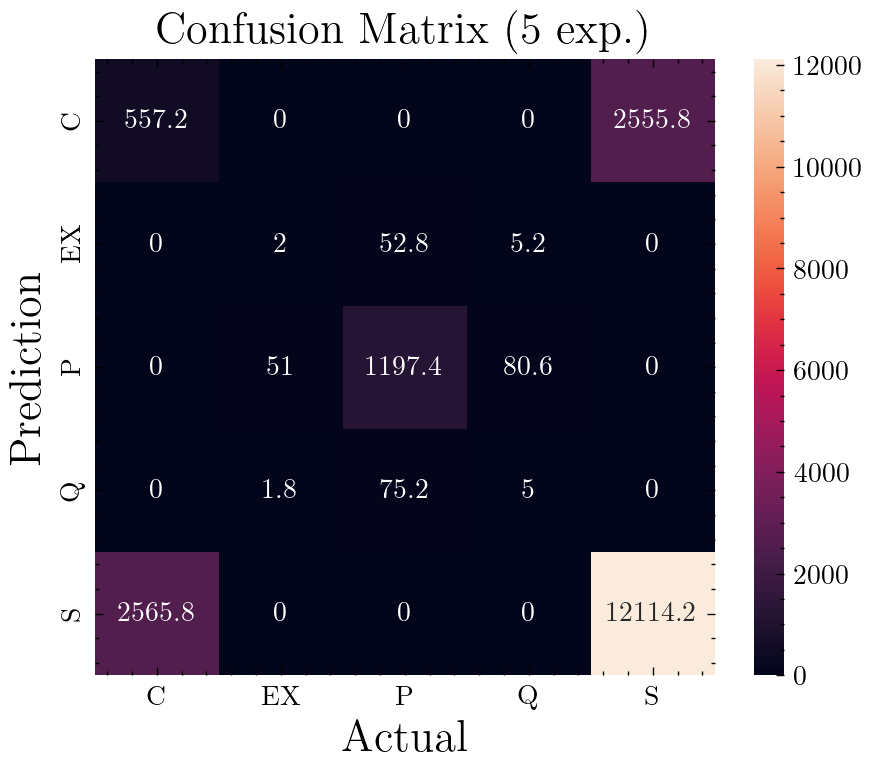

In [170]:
fig, ax = plt.subplots(figsize=(5, 4))

# create a confusion matrix
# cm = confusion_matrix(test_all_punc_target, test_all_punc_preds) / n_experiments
classes = sorted(END_PUNC + INTR_PUNC)  # alphabetic order

# plot the confusion matrix
sns.heatmap(cm / n_experiments, annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.ylabel('Prediction', fontsize=lables_fs)
plt.xlabel('Actual', fontsize=lables_fs)
plt.title(f'Confusion Matrix ({n_experiments} exp.)', fontsize=lables_fs)
plt.show()

In [158]:
# precision = TP / (TP + FP)
# precision = precision_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
precision = precision / n_experiments
# recall = TP / (TP + FN)
# recall = recall_score(test_all_punc_target, test_all_punc_preds, average=None, zero_division=np.nan)
recall = recall / n_experiments
# f1 = 2TP / (2TP + FP + FN)
# f1 = f1_score(test_all_punc_target, test_all_punc_preds, average=None)
f1 = f1 / n_experiments

In [159]:
metrics_names = ['Precision', 'Recall', 'F1 score']
metrics = {'Precision': precision, 'Recall': recall, 'F1 score': f1}
col_w = 18

print(' ' * col_w + '|' + ''.join([f"{NAMES_PUNC[token] + (col_w - len(NAMES_PUNC[token])) * ' '}|" for token in classes]))  # header
print(''.join(['-' * col_w + '|' for _ in range(len(classes) + 1)]) )
for ind, metric_name in enumerate(metrics_names):
    row = f"{metric_name + (col_w - len(metric_name)) * ' '}|"
    for score in metrics[metric_name]:
        score_str = f'{score:.6f}'
        row += f"{score_str + (col_w - len(score_str)) * ' '}|"
    print(row)

                  |comma (`,`)       |exclamation (`!`) |period (`.`)      |question (`?`)    |space (` `)       |
------------------|------------------|------------------|------------------|------------------|------------------|
Precision         |0.178359          |0.036377          |0.903420          |0.054386          |0.825783          |
Recall            |0.178991          |0.033333          |0.900978          |0.060976          |0.825218          |
F1 score          |0.178664          |0.034584          |0.902196          |0.057425          |0.825498          |


### Metrics (NLP)

A **NLP metric** that can be used here is [_Levenshtein distance_](https://en.wikipedia.org/wiki/Levenshtein_distance) between target and predicted sequences of punctuation tokens.

In [116]:
# example
levenshtein_distance('S S S S C S S S S P', 'S S S S S S S S C P')

2

In [163]:
n_levenshtein_experiments = 10

target_vs_pred_df = pd.DataFrame()
target_vs_pred_df['target'] = y_test

for n in tqdm(range(n_levenshtein_experiments)):
    y_pred = predict_statistic_model(X_test, intr_probas, end_probas)
    
    target_vs_pred_df['predicted'] = y_pred

    if n == 0:
        target_vs_pred_df['levenshtein'] = target_vs_pred_df.apply(
            lambda row: levenshtein_distance(row.target, row.predicted),
            axis = 1
        )
    else:
        target_vs_pred_df['levenshtein'] = target_vs_pred_df.apply(
            lambda row: row.levenshtein + levenshtein_distance(row.target, row.predicted),
            axis = 1
        )

target_vs_pred_df['levenshtein'] /= n_levenshtein_experiments  # metrics averaging over experiments
target_vs_pred_df.sample(5)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.25it/s]


,target,predicted,levenshtein
3158,S S S S S S C S S S C S S C S S S C S S S C S S P,S S S S S S S S C S S S S S S S S S C S C S S C P,7.3
2458,S S S C C C C S C S S P,S S S S S S S S S S S P,5.2
1417,S C S S S P,S S S S C P,1.7
1123,S S S S C S S S S S S P,C S S S S S S S S S S P,2.5
2425,S S S S S S S C S S S S S S S S P,S S S S S S S S C C S S C C S S Q,4.5


In [164]:
print(f'Levenshtein distance ({n_levenshtein_experiments} exp.)')
print(f"\tMean: {target_vs_pred_df['levenshtein'].mean()}")
print(f"\tMIN : {target_vs_pred_df['levenshtein'].min()}")
print(f"\tMAX : {target_vs_pred_df['levenshtein'].max()}")

Levenshtein distance (10 exp.)
	Mean: 3.708361658735554
	MIN : 0.7
	MAX : 9.8


In [174]:
target_vs_pred_df['len'] = target_vs_pred_df.apply(
    lambda row: len(row.target.split(' ')),
    axis = 1
)

print(f"Mean length of sequence: {target_vs_pred_df['len'].mean():.2f}")

Mean length of sequence: 13.10
